# Truncated Skewed Levy Distribution

In [1]:
from levy_distribution import pdf_from_cf, dump_levy, load_levy, kde_fit_levy
import matplotlib.pyplot as plt
import numpy as np
import time
from scipy.stats import gaussian_kde
import pandas as pd
from arch import arch_model

## Training data

In [8]:
dfs = pd.read_excel('../Indices_Data.xlsx', sheet_name=None)

euronext100 = dfs['Euronext100'][['Date', 'Close']]
stoxx50e = dfs['Stoxx50E'][['Date', 'Close']]
snp500 = dfs['S&P500'][['Date', 'Close']]
data = snp500.copy()
data = data[(data['Date'] > '2006-01-01') & (data['Date'] < '2017-12-31')].reset_index()

data['Returns'] = np.log(data['Close'] / data['Close'].shift(1))*100
data['10 Days Returns'] = data['Returns'].rolling(window=10).sum()
data['210 Days Returns'] = data['Returns'].rolling(window=210).sum()
data = data.iloc[251:].reset_index()

In [ ]:
print(data[['Date','Returns']])

## Fit the Garch
The Garch model:

In [17]:
def model(returns : pd.DataFrame, omega, alpha, gamma, beta, kappa):
    t_max = len(returns)
    epsilon = np.zeros(t_max)
    sigma = np.zeros(t_max+1)

    sigma[0]= returns.std()
    
    for t in range(t_max):
        if returns[t]<0:
            leverage=1
        else:
            leverage=0
        epsilon[t] = returns[t]/sigma[t]
        sigma[t+1] = np.power(omega + alpha*np.power(np.abs(epsilon[t]),kappa)+gamma*leverage*np.power(np.abs(epsilon[t]),kappa)+beta*np.power(sigma[t],kappa), 1/kappa)
    return sigma

In [ ]:
garch = arch_model(data['Returns'], p=1, q=1, o=1, power=1.76, dist='normal')
results=garch.fit()

In [ ]:
results.summary()

In [ ]:
print(results.params)

In [ ]:
mean = results.params['mu']
std_dev = model(data['Returns'],omega=results.params['omega'],alpha=results.params['alpha[1]'],gamma = results.params['gamma[1]'], beta=results.params['beta[1]'], kappa=1.76)

In [ ]:
data['Standardized Returns'] = (data['Returns']-mean)/std_dev[:-1]
data['Volatilities'] = std_dev[:-1]

In [ ]:
kde= gaussian_kde(data['Standardized Returns'])
x_values = np.linspace(-5,5,1000)
y_kde=kde(x_values)

In [ ]:
plt.figure(figsize=(7, 5))
plt.hist(data['Standardized Returns'], range=(-5, 5), bins=60, density=True, color='green')
plt.plot(x_values,y_kde, color='red', linewidth = 2)
plt.show()

## KDE Fit the PDF
On the standardized normal

In [ ]:
n_points = 9
alpha_grid = np.linspace(0.75,0.81,n_points)
lam_grid = np.linspace(1.60,1.80,n_points)
beta_grid = np.linspace(-0.12,-0.18,n_points)

In [ ]:
kde_opt = kde_fit_levy(data['Standardized Returns'],alpha_grid=alpha_grid, lam_grid=lam_grid, beta_grid=beta_grid, n = 100, x_max=15, k_max=15.0, ln_2_k_points=10)

In [ ]:
print(kde_opt)

In [ ]:
x_values = np.linspace(-5, 5, 1000)
start_time = time.time()
y_values = pdf_from_cf(x_values, 0, 1, kde_opt[0], kde_opt[1], kde_opt[2], k_max=15.0, ln_2_k_points=12, x_lim=25)
print("It took %s seconds for 1000 evaluations" % (time.time() - start_time))

In [ ]:
fig, ax = plt.subplots(figsize=(15,7), facecolor = 'white',dpi=200)
ax.grid(color='#E8E8E9', linestyle='-', linewidth=0.8)
ax.hist(data['Standardized Returns'], bins=90, density=True, color='#E8E8E8', edgecolor='#000000', label='S&P500 Standardized Returns')
ax.plot(x_values, y_kde, label='Kernel Density Estimation', color='#000000', linewidth=1.75)
ax.plot(x_values, y_values, label='Fitted Truncated Lévy', color='#C00000', linewidth=1.75)

ax.legend()

#sns.despine(ax=ax, left=True, bottom=True)

ax.set_title("Truncated Lévy: " + str(np.round(0.00,2)) + ' ' +  str(np.round(1.00,2)) + ' ' +   str(np.round(kde_opt[0],2)) + ' ' +   str(np.round(kde_opt[1],2)) + ' ' +   str(np.round(kde_opt[2],2)))

plt.show()

## Save the distribution points

In [ ]:
# dump_levy(0,1,kde_opt[0],kde_opt[1],kde_opt[2],x_min=-20,x_max=20,x_points=40000,k_max=50,ln_2_k_points=15)

In [2]:
levy=load_levy('truncated_levy_0_1_0.76_1.68_-0.16.npz')

## VaR Calculation

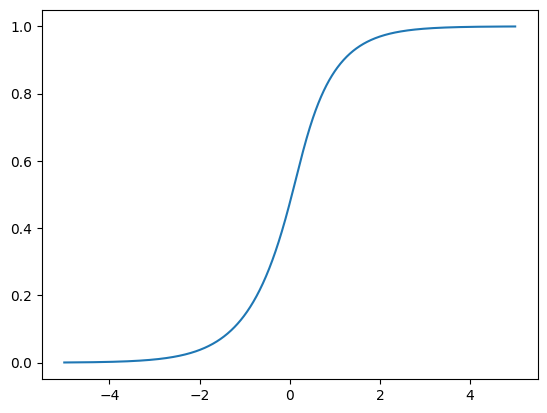

In [16]:
x = np.linspace(-5,5,1000)
y= levy.cdf(x)
plt.plot(x,y)
plt.show()

In [5]:
first_percentile = levy.ppf(0.01, loc=0.0, scale=1.0)
print(first_percentile)

-2.962705133886335


In [6]:
data['1 Day VaR'] = first_percentile*data['Volatilities']

NameError: name 'data' is not defined

In [ ]:
plt.figure(figsize=(15,7))
plt.plot(data['Date'],data['Returns'],label='1 Day Returns', color='black',linewidth = 0.3)
plt.plot(data['Date'],data['1 Day VaR'],label='1 Day VaR', color = '#C00000', linewidth = 0.3)
plt.title('Training Data')
plt.legend()
plt.show()

In [ ]:
data['Violations']=data['1 Day VaR'] > data['Returns']

In [ ]:
violations=data['Violations'].mean()*100

In [ ]:
print(violations,'%')

## Test Data

In [ ]:
test_data= snp500.copy()
test_data = test_data[(test_data['Date'] > '2017-12-31') & (test_data['Date'] < '2024-12-31')].reset_index()
test_data['Returns'] = np.log(test_data['Close'] / test_data['Close'].shift(1)) * 100
test_data = test_data.dropna().reset_index()

In [ ]:
test_data['Returns']

In [ ]:
mean = results.params['mu']
test_std_dev = model(test_data['Returns'],omega=results.params['omega'],alpha=results.params['alpha[1]'],gamma = results.params['gamma[1]'], beta=results.params['beta[1]'], kappa=1.76)

In [ ]:
test_std_dev

In [ ]:
test_data['Standardized Returns'] = (test_data['Returns']-mean)/test_std_dev[:-1]
test_data['Volatilities'] = test_std_dev[:-1]
test_data['1 Day VaR'] = first_percentile * test_data['Volatilities']
test_data['Violations'] = test_data['1 Day VaR'] > test_data['Returns']
test_violations=test_data['Violations'].mean()*100

In [ ]:
print(test_violations)

In [ ]:
plt.figure(figsize=(15,7))
plt.plot(test_data['Date'],test_data['Returns'],label='1 Day Returns', color='black',linewidth = 0.3)
plt.plot(test_data['Date'],test_data['1 Day VaR'],label='1 Day VaR', color = '#C00000', linewidth = 0.3)
plt.title('Test Data')
plt.legend()
plt.show()

# Scaling to 10 Days VaR

In [13]:
biweekly_garch = arch_model(data['10 Days Returns'], p=1, q=1, o=1, power=1.76, dist='normal')
biweekly_results=garch.fit()

Iteration:      1,   Func. Count:      7,   Neg. LLF: 19971.475758929766
Iteration:      2,   Func. Count:     18,   Neg. LLF: 6280561613.784792
Iteration:      3,   Func. Count:     26,   Neg. LLF: 9000.12764159297
Iteration:      4,   Func. Count:     34,   Neg. LLF: 6213.016089379715
Iteration:      5,   Func. Count:     41,   Neg. LLF: 6082.262054177983
Iteration:      6,   Func. Count:     49,   Neg. LLF: 6028.822240984374
Iteration:      7,   Func. Count:     56,   Neg. LLF: 6090.965030451453
Iteration:      8,   Func. Count:     63,   Neg. LLF: 6014.695000800369
Iteration:      9,   Func. Count:     69,   Neg. LLF: 6014.571613324219
Iteration:     10,   Func. Count:     75,   Neg. LLF: 6014.53200032488
Iteration:     11,   Func. Count:     81,   Neg. LLF: 6014.52085854295
Iteration:     12,   Func. Count:     87,   Neg. LLF: 6014.519598730594
Iteration:     13,   Func. Count:     93,   Neg. LLF: 6014.518678514619
Iteration:     14,   Func. Count:     99,   Neg. LLF: 6014.5181685

In [14]:
biweekly_results.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
               Constant Mean - Asym. Power GARCH (power: 1.8) Model Results               
==========================================================================================
Dep. Variable:                    10 Days Returns   R-squared:                       0.000
Mean Model:                         Constant Mean   Adj. R-squared:                  0.000
Vol Model:         Asym. Power GARCH (power: 1.8)   Log-Likelihood:               -6014.52
Distribution:                              Normal   AIC:                           12039.0
Method:                        Maximum Likelihood   BIC:                           12068.7
                                                    No. Observations:                 2769
Date:                            Thu, Mar 27 2025   Df Residuals:                     2768
Time:                                    10:12:19   Df Model:                            1
                               Mean Model                               
========================================================================
                 coef    std err          t      P>|t|  95.0% Conf. Int.
------------------------------------------------------------------------
mu             0.7806  8.621e-02      9.054  1.381e-19 [  0.612,  0.950]
                             Volatility Model                             
==========================================================================
                 coef    std err          t      P>|t|    95.0% Conf. Int.
--------------------------------------------------------------------------
omega          0.5775      0.150      3.856  1.155e-04   [  0.284,  0.871]
alpha[1]       0.6087  6.793e-02      8.961  3.211e-19   [  0.476,  0.742]
gamma[1]       0.0918  4.210e-02      2.180  2.925e-02 [9.266e-03,  0.174]
beta[1]        0.3108  8.135e-02      3.820  1.333e-04   [  0.151,  0.470]
==========================================================================

Covariance estimator: robust
"""

In [19]:
mean = biweekly_results.params['mu']
std_dev = model(data['10 Days Returns'],omega=biweekly_results.params['omega'],alpha=biweekly_results.params['alpha[1]'],gamma = biweekly_results.params['gamma[1]'], beta=biweekly_results.params['beta[1]'], kappa=1.76)

In [ ]:
data['Standardized 10Returns'] = (data['Returns']-mean)/std_dev[:-1]
data['Volatilities'] = std_dev[:-1]